Calculated Discharge Current: 7.57 A


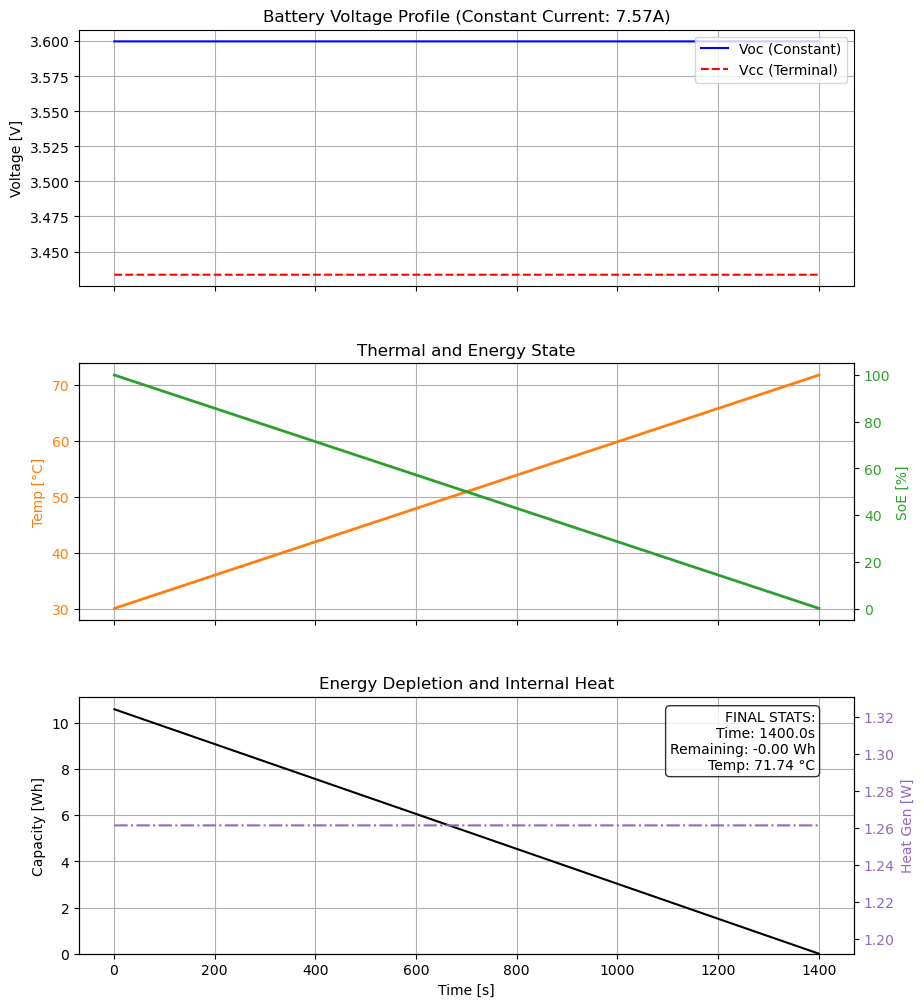

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# %% --- CELL PARAMETERS & SETTINGS ---
# Simulation Targets
Target_Capacity_Wh = 10.6
Target_Time_s = 1400
Target_Capacity_J = Target_Capacity_Wh * 3600

# Physical Parameters
R = 0.022              # Internal Resistance [Ohms]
m = 0.047              # Cell Mass [kg]
Cp = 900               # Specific Heat Capacity [J/kgK]
V_min = 2.5            # Discharge Cutoff [V]
T_initial = 30.0       # Initial Temperature [C]
V_const_OCV = 3.6      # Constant Voltage assumption

# Calculated Constant Current (C-rate derived)
# Power = Energy / Time -> P = 10.6Wh / (1400/3600 h) = ~27.25W
# I = P / V_avg. Approximating P_avg required to drain in 1400s:
P_required = Target_Capacity_J / Target_Time_s
I_const = P_required / V_const_OCV 

print(f"Calculated Discharge Current: {I_const:.2f} A")

# %% --- SIMULATION SETUP ---
dt = 1                 # Time step [s]
joules_used_total = 0
max_steps = int(Target_Time_s * 1.5) # Safety buffer
results = []

# %% --- SIMULATION LOOP ---
step = 0
current_temp = T_initial

while True:
    step += 1
    t = step * dt
    
    # 1. State of Energy
    current_joules = min(joules_used_total, Target_Capacity_J)
    SoE_val = (Target_Capacity_J - current_joules) / Target_Capacity_J
    
    # 2. Voltage Logic
    # If you later want a lookup table, replace this line with an interp function
    Voc = V_const_OCV 
    
    # 3. Calculate Terminal Voltage (Vcc)
    # Vcc = OCV - I*R
    Vcc = Voc - (I_const * R)
    P_elec = Vcc * I_const
    
    # 4. Thermal Logic
    # Q_gen = I^2 * R
    Q_gen = (I_const ** 2) * R
    
    # Temperature rise = Q / (m * Cp)
    # dT = (Q_gen * dt) / (m * Cp)
    current_temp = current_temp + (Q_gen * dt) / (m * Cp)
    
    # 5. Energy Integration
    # Total Energy Used = Electrical Energy Out + Heat Loss
    joules_used_total = joules_used_total + (P_elec * dt) + (Q_gen * dt)
    
    # Store results
    # Time, Voc, Vcc, Temp, SoE, Capacity_Remaining_Wh, Heat_Gen_W
    results.append([
        t, 
        Voc, 
        Vcc, 
        current_temp, 
        SoE_val * 100, 
        (Target_Capacity_J - joules_used_total) / 3600,
        Q_gen
    ])
    
    # 6. Break Conditions
    if (Vcc <= V_min) or (joules_used_total >= Target_Capacity_J):
        break
    if step >= max_steps:
        break

# Convert to Numpy Array for plotting
results = np.array(results)

# Final Stats
f_time = results[-1, 0]
f_Wh = results[-1, 5]
f_SoE = results[-1, 4]
f_Temp = results[-1, 3]

# %% --- PLOTTING ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

t_axis = results[:, 0]

# Subplot 1: Voltages
ax1.plot(t_axis, results[:, 1], 'b-', label='Voc (Constant)', linewidth=1.5)
ax1.plot(t_axis, results[:, 2], 'r--', label='Vcc (Terminal)', linewidth=1.5)
ax1.set_ylabel('Voltage [V]')
ax1.set_title(f'Battery Voltage Profile (Constant Current: {I_const:.2f}A)')
ax1.grid(True)
ax1.legend(loc='upper right')

# Subplot 2: Thermal & SoE
color_temp = 'tab:orange'
color_soe = 'tab:green'

ax2.set_ylabel('Temp [°C]', color=color_temp)
ax2.plot(t_axis, results[:, 3], color=color_temp, linewidth=2, label='Temp')
ax2.tick_params(axis='y', labelcolor=color_temp)

ax2_twin = ax2.twinx()  # Create a second y-axis
ax2_twin.set_ylabel('SoE [%]', color=color_soe)
ax2_twin.plot(t_axis, results[:, 4], color=color_soe, linewidth=2, label='SoE')
ax2_twin.tick_params(axis='y', labelcolor=color_soe)
ax2.set_title('Thermal and Energy State')
ax2.grid(True)

# Subplot 3: Wh Remaining & Heat Gen
color_wh = 'black'
color_heat = 'tab:purple'

ax3.set_ylabel('Capacity [Wh]', color=color_wh)
ax3.plot(t_axis, results[:, 5], color=color_wh, linewidth=1.5)
ax3.tick_params(axis='y', labelcolor=color_wh)
ax3.set_xlabel('Time [s]')
ax3.set_ylim(bottom=0)

ax3_twin = ax3.twinx()
ax3_twin.set_ylabel('Heat Gen [W]', color=color_heat)
ax3_twin.plot(t_axis, results[:, 6], color=color_heat, linestyle='-.', linewidth=1.5)
ax3_twin.tick_params(axis='y', labelcolor=color_heat)
ax3.set_title('Energy Depletion and Internal Heat')
ax3.grid(True)

# Add Text Box
stat_text = (f"FINAL STATS:\nTime: {f_time:.1f}s\n"
             f"Remaining: {f_Wh:.2f} Wh\n"
             f"Temp: {f_Temp:.2f} °C")
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# CHANGED: Coordinates set to 0.95, 0.95 (Top Right)
# CHANGED: Alignments set to 'top' and 'right' so the box grows inward
ax3.text(0.95, 0.95, stat_text, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.show()

this one has cell ocv lookup

CSV Lookup Table Loaded Successfully.


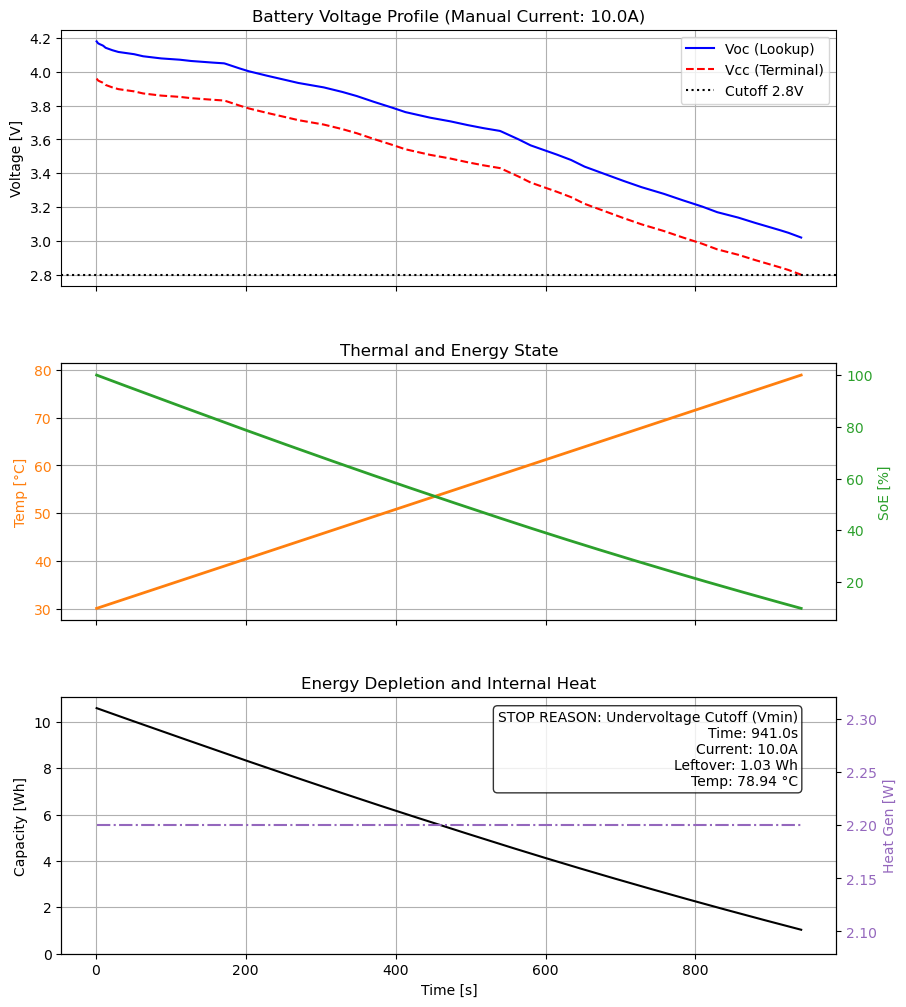

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# %% --- CELL PARAMETERS & SETTINGS ---
# Manual Current Setting
I_const = 10.0         # <--- SET YOUR MANUAL AMPS HERE

# Simulation Targets
Target_Capacity_Wh = 10.6
Target_Capacity_J = Target_Capacity_Wh * 3600

# Physical Parameters
R = 0.022              # Internal Resistance [Ohms]
m = 0.047              # Cell Mass [kg]
Cp = 900               # Specific Heat Capacity [J/kgK]
V_min = 2.8            # Discharge Cutoff [V] (Updated to 2.8V)
T_initial = 30.0       # Initial Temperature [C]

# %% --- DATA IMPORT ---
csv_path = r"C:\Pythoning\Vtc6BasicCellLookup.csv"

try:
    # Reading CSV
    lookup_data = pd.read_csv(csv_path)
    voc_vec = lookup_data.iloc[:, 0].values
    raw_joules = lookup_data.iloc[:, 3].values
    
    # Normalize and scale curve
    joules_vec = (raw_joules / np.max(raw_joules)) * Target_Capacity_J
    
    # Create Interpolation Function
    voc_interpolator = interp1d(joules_vec, voc_vec, kind='linear', fill_value="extrapolate")
    print("CSV Lookup Table Loaded Successfully.")

except Exception as e:
    print(f"Error loading CSV: {e}")
    print("Falling back to constant 3.6V OCV.")
    voc_interpolator = lambda x: 3.6 

# %% --- SIMULATION SETUP ---
dt = 1                 # Time step [s]
joules_used_total = 0
max_steps = 400000     # Large number to ensure loop runs until physical cutoff
results = []
termination_reason = "Max Steps Reached"

# %% --- SIMULATION LOOP ---
step = 0
current_temp = T_initial

while True:
    step += 1
    t = step * dt
    
    # 1. State of Energy
    current_joules = min(joules_used_total, Target_Capacity_J)
    SoE_val = (Target_Capacity_J - current_joules) / Target_Capacity_J
    
    # 2. Voltage Lookup
    Voc = float(voc_interpolator(current_joules))
    
    # 3. Calculate Terminal Voltage (Vcc)
    # Vcc drops due to IR drop. If Current is high, Vcc hits 2.8V early.
    Vcc = Voc - (I_const * R)
    P_elec = Vcc * I_const
    
    # 4. Thermal Logic
    Q_gen = (I_const ** 2) * R
    current_temp = current_temp + (Q_gen * dt) / (m * Cp)
    
    # 5. Energy Integration
    joules_used_total = joules_used_total + (P_elec * dt) + (Q_gen * dt)
    
    # Store results
    results.append([
        t, 
        Voc, 
        Vcc, 
        current_temp, 
        SoE_val * 100, 
        (Target_Capacity_J - joules_used_total) / 3600,
        Q_gen
    ])
    
    # 6. Break Conditions
    if Vcc <= V_min:
        termination_reason = "Undervoltage Cutoff (Vmin)"
        break
    if joules_used_total >= Target_Capacity_J:
        termination_reason = "Capacity Depleted"
        break
    if step >= max_steps:
        break

results = np.array(results)

# Final Stats
f_time = results[-1, 0]
f_Wh = results[-1, 5]
f_SoE = results[-1, 4]
f_Temp = results[-1, 3]

# %% --- PLOTTING ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

t_axis = results[:, 0]

# Subplot 1: Voltages
ax1.plot(t_axis, results[:, 1], 'b-', label='Voc (Lookup)', linewidth=1.5)
ax1.plot(t_axis, results[:, 2], 'r--', label='Vcc (Terminal)', linewidth=1.5)
ax1.axhline(y=V_min, color='k', linestyle=':', label=f'Cutoff {V_min}V') # Cutoff Line
ax1.set_ylabel('Voltage [V]')
ax1.set_title(f'Battery Voltage Profile (Manual Current: {I_const:.1f}A)')
ax1.grid(True)
ax1.legend(loc='upper right')

# Subplot 2: Thermal & SoE
color_temp = 'tab:orange'
color_soe = 'tab:green'

ax2.set_ylabel('Temp [°C]', color=color_temp)
ax2.plot(t_axis, results[:, 3], color=color_temp, linewidth=2, label='Temp')
ax2.tick_params(axis='y', labelcolor=color_temp)

ax2_twin = ax2.twinx()
ax2_twin.set_ylabel('SoE [%]', color=color_soe)
ax2_twin.plot(t_axis, results[:, 4], color=color_soe, linewidth=2, label='SoE')
ax2_twin.tick_params(axis='y', labelcolor=color_soe)
ax2.set_title('Thermal and Energy State')
ax2.grid(True)

# Subplot 3: Wh Remaining & Heat Gen
color_wh = 'black'
color_heat = 'tab:purple'

ax3.set_ylabel('Capacity [Wh]', color=color_wh)
ax3.plot(t_axis, results[:, 5], color=color_wh, linewidth=1.5)
ax3.tick_params(axis='y', labelcolor=color_wh)
ax3.set_xlabel('Time [s]')
ax3.set_ylim(bottom=0)

ax3_twin = ax3.twinx()
ax3_twin.set_ylabel('Heat Gen [W]', color=color_heat)
ax3_twin.plot(t_axis, results[:, 6], color=color_heat, linestyle='-.', linewidth=1.5)
ax3_twin.tick_params(axis='y', labelcolor=color_heat)
ax3.set_title('Energy Depletion and Internal Heat')
ax3.grid(True)

# Add Text Box (Top Right)
stat_text = (f"STOP REASON: {termination_reason}\n"
             f"Time: {f_time:.1f}s\n"
             f"Current: {I_const:.1f}A\n"
             f"Leftover: {f_Wh:.2f} Wh\n"
             f"Temp: {f_Temp:.2f} °C")
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax3.text(0.95, 0.95, stat_text, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.show()

Incorporating max heat limit and searching method for max current draw


CSV Lookup Loaded.
Searching for Max Current to survive 1400s...
Optimization Complete.
Max Safe Current: 5.862 A
Limiting Factor at higher currents: Overheat (55C)


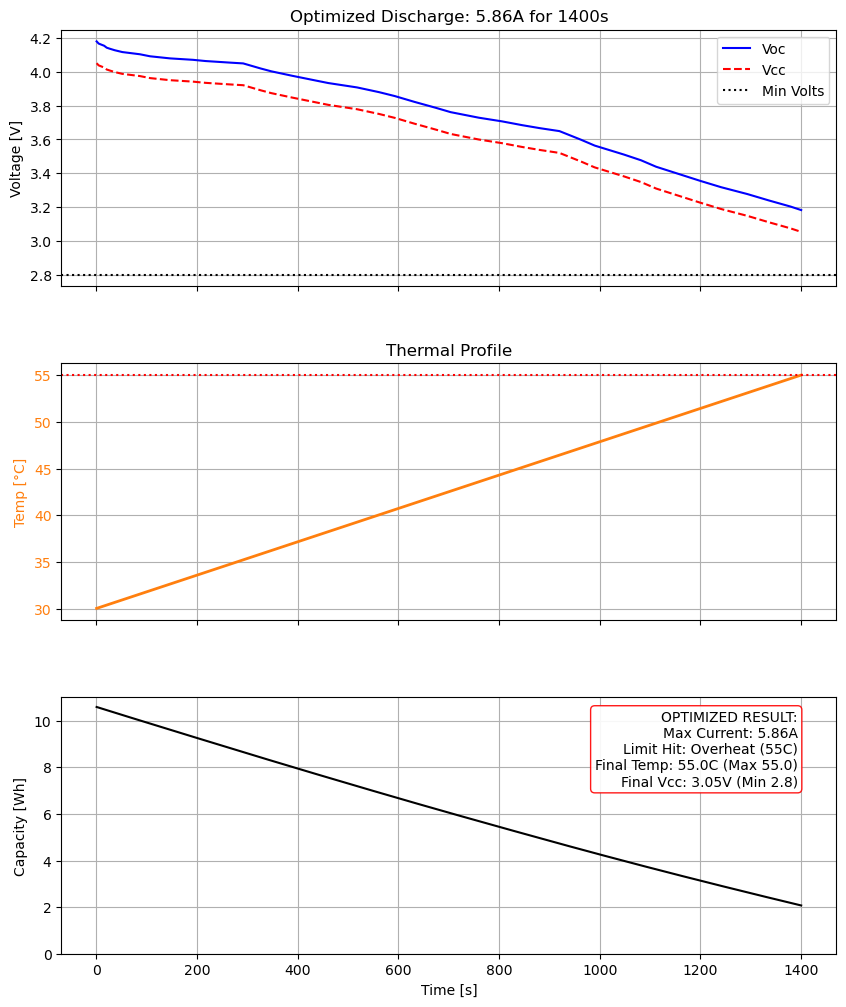

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# %% --- CONFIGURATION ---
Target_Time_s = 1400
Target_Capacity_Wh = 10.6
Target_Capacity_J = Target_Capacity_Wh * 3600

# Constraints
V_min = 2.8            # Undervoltage Limit
T_max = 55.0           # Overheat Limit
T_initial = 30.0       # Start Temp

# Physical Parameters
R = 0.022              # Ohms
m = 0.047              # kg
Cp = 900               # J/kgK

# %% --- DATA IMPORT ---
csv_path = r"C:\Pythoning\Vtc6BasicCellLookup.csv"
try:
    lookup_data = pd.read_csv(csv_path)
    voc_vec = lookup_data.iloc[:, 0].values
    raw_joules = lookup_data.iloc[:, 3].values
    joules_vec = (raw_joules / np.max(raw_joules)) * Target_Capacity_J
    voc_interpolator = interp1d(joules_vec, voc_vec, kind='linear', fill_value="extrapolate")
    print("CSV Lookup Loaded.")
except:
    print("CSV not found, using constant 3.6V.")
    voc_interpolator = lambda x: 3.6

# %% --- SIMULATION FUNCTION ---
def run_simulation(test_current, detailed=False):
    """
    Runs a simulation. 
    If detailed=True, returns arrays for plotting.
    If detailed=False, returns just the failure time and reason (for the search algorithm).
    """
    dt = 1
    joules_used = 0
    current_temp = T_initial
    step = 0
    max_steps = int(Target_Time_s * 1.5)
    
    # Storage for plotting
    history = []
    
    stop_reason = "Target Time Reached"
    
    while True:
        step += 1
        t = step * dt
        
        # 1. State of Energy
        current_joules_state = min(joules_used, Target_Capacity_J)
        
        # 2. Voltage
        Voc = float(voc_interpolator(current_joules_state))
        Vcc = Voc - (test_current * R)
        
        # 3. Thermal
        Q_gen = (test_current ** 2) * R
        current_temp += (Q_gen * dt) / (m * Cp)
        
        # 4. Energy
        P_elec = Vcc * test_current
        joules_used += (P_elec * dt) + (Q_gen * dt)
        
        if detailed:
            SoE = (Target_Capacity_J - current_joules_state) / Target_Capacity_J
            history.append([t, Voc, Vcc, current_temp, SoE*100, (Target_Capacity_J-joules_used)/3600, Q_gen])

        # 5. Check Constraints
        if Vcc <= V_min:
            stop_reason = "Undervoltage (2.8V)"
            break
        if current_temp >= T_max:
            stop_reason = "Overheat (55C)"
            break
        if joules_used >= Target_Capacity_J:
            stop_reason = "Empty Capacity"
            break
        if t >= Target_Time_s and not detailed:
            # Optimization shortcut: If we survived to target time, we passed.
            break
        if detailed and step >= max_steps:
            break
            
    if detailed:
        return np.array(history), stop_reason
    else:
        return t, stop_reason

# %% --- BINARY SEARCH ALGORITHM ---
print(f"Searching for Max Current to survive {Target_Time_s}s...")

low_I = 0.1
high_I = 50.0  # Reasonable upper bound
best_I = 0.0
limiting_factor = "None"

for _ in range(20): # 20 iterations gives high precision
    mid_I = (low_I + high_I) / 2
    survived_time, reason = run_simulation(mid_I, detailed=False)
    
    if survived_time >= Target_Time_s:
        # We survived! Try higher current
        best_I = mid_I
        low_I = mid_I
    else:
        # We died too early. Lower current.
        limiting_factor = reason
        high_I = mid_I

print(f"Optimization Complete.")
print(f"Max Safe Current: {best_I:.3f} A")
print(f"Limiting Factor at higher currents: {limiting_factor}")

# %% --- FINAL RUN & PLOTTING ---
results, final_reason = run_simulation(best_I, detailed=True)

# Extract stats
f_time = results[-1, 0]
f_Wh = results[-1, 5]
f_SoE = results[-1, 4]
f_Temp = results[-1, 3]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

t_axis = results[:, 0]

# 1. Voltage
ax1.plot(t_axis, results[:, 1], 'b-', label='Voc')
ax1.plot(t_axis, results[:, 2], 'r--', label='Vcc')
ax1.axhline(y=V_min, color='k', linestyle=':', label='Min Volts')
ax1.set_ylabel('Voltage [V]')
ax1.set_title(f'Optimized Discharge: {best_I:.2f}A for {Target_Time_s}s')
ax1.legend(loc='upper right')
ax1.grid(True)

# 2. Thermal
color_temp = 'tab:orange'
ax2.plot(t_axis, results[:, 3], color=color_temp, linewidth=2, label='Temp')
ax2.axhline(y=T_max, color='r', linestyle=':', label='Max Temp')
ax2.set_ylabel('Temp [°C]', color=color_temp)
ax2.tick_params(axis='y', labelcolor=color_temp)
ax2.set_title('Thermal Profile')
ax2.grid(True)

# 3. Energy
color_wh = 'black'
ax3.plot(t_axis, results[:, 5], color=color_wh, linewidth=1.5)
ax3.set_ylabel('Capacity [Wh]', color=color_wh)
ax3.set_xlabel('Time [s]')
ax3.set_ylim(bottom=0)
ax3.grid(True)

# Text Box
stat_text = (f"OPTIMIZED RESULT:\n"
             f"Max Current: {best_I:.2f}A\n"
             f"Limit Hit: {limiting_factor}\n"
             f"Final Temp: {f_Temp:.1f}C (Max {T_max})\n"
             f"Final Vcc: {results[-1, 2]:.2f}V (Min {V_min})")

props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='red')
ax3.text(0.95, 0.95, stat_text, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.show()

Multi plot to show how cooling enables higher cell thermal stresses

h    | Max I      | Limit           | Temp     | Vcc      | Rem Wh
---------------------------------------------------------------------------
0    | 5.86 A     | Overheat        | 55.0 C   | 3.05 V | 2.07
5    | 6.79 A     | Overheat        | 55.0 C   | 2.85 V | 0.95
15   | 6.98 A     | Undervoltage    | 46.1 C   | 2.80 V | 0.73
25   | 6.98 A     | Undervoltage    | 40.9 C   | 2.80 V | 0.73


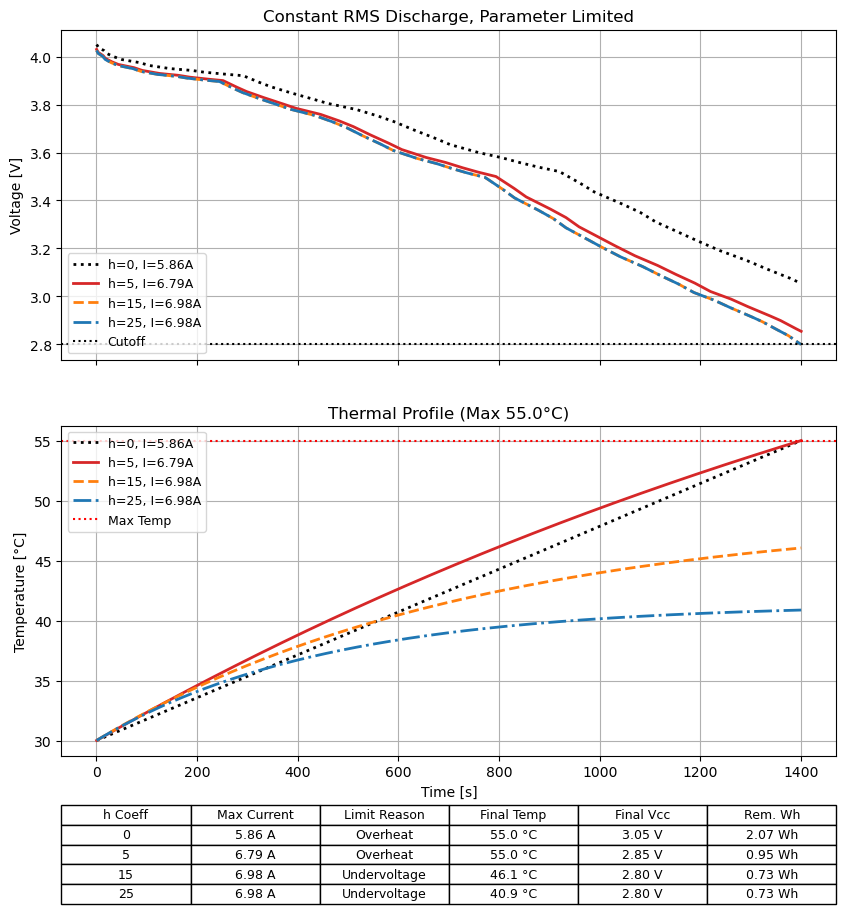

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# %% --- 1. CONFIGURATION & CELL GEOMETRY ---
Target_Time_s = 1400
Target_Capacity_Wh = 10.6
Target_Capacity_J = Target_Capacity_Wh * 3600

# Limits
V_min = 2.8            # Undervoltage Limit
T_max = 55.0           # Overheat Limit
T_initial = 30.0       # Start Temp & Ambient Temp

# Physical Parameters
R = 0.022              # Ohms
m = 0.047              # kg
Cp = 900               # J/kgK

# Geometry (18650)
d_mm = 18
L_mm = 65
d_m = d_mm / 1000
L_m = L_mm / 1000

# Area Calculation
Area_total_m2 = (np.pi * d_m * L_m) + (2 * np.pi * (d_m/2)**2)
Exposed_Factor = 0.9
Coolable_Area_m2 = Area_total_m2 * Exposed_Factor

# %% --- 2. DATA IMPORT ---
csv_path = r"C:\Pythoning\Vtc6BasicCellLookup.csv"
try:
    lookup_data = pd.read_csv(csv_path)
    voc_vec = lookup_data.iloc[:, 0].values
    raw_joules = lookup_data.iloc[:, 3].values
    joules_vec = (raw_joules / np.max(raw_joules)) * Target_Capacity_J
    voc_interpolator = interp1d(joules_vec, voc_vec, kind='linear', fill_value="extrapolate")
except:
    voc_interpolator = lambda x: 3.6

# %% --- 3. SIMULATION CORE ---
def run_simulation(current, h_coeff, detailed=False):
    dt = 1
    joules_used = 0
    current_temp = T_initial
    step = 0
    max_steps = int(Target_Time_s * 1.5)
    
    history = []
    stop_reason = "Time Reached"
    
    while True:
        step += 1
        t = step * dt
        
        # A. Lookup OCV
        current_joules_state = min(joules_used, Target_Capacity_J)
        Voc = float(voc_interpolator(current_joules_state))
        
        # B. Electrical Math
        Vcc = Voc - (current * R)
        P_elec = Vcc * current
        
        # C. Thermal Math (Newton's Law of Cooling)
        Q_gen = (current ** 2) * R
        Q_cool = h_coeff * Coolable_Area_m2 * (current_temp - T_initial)
        
        # Update Temp
        current_temp += ((Q_gen - Q_cool) * dt) / (m * Cp)
        
        # D. Energy Math
        joules_used += (P_elec * dt) + (Q_gen * dt)
        
        if detailed:
            # Saving extra param (joules_used) for final calculation
            history.append([t, Voc, Vcc, current_temp, joules_used])

        # E. Constraints
        if Vcc <= V_min:
            stop_reason = "Undervoltage"
            break
        if current_temp >= T_max:
            stop_reason = "Overheat"
            break
        if joules_used >= Target_Capacity_J:
            stop_reason = "Empty"
            break
        if t >= Target_Time_s and not detailed:
            break # Optimization Success
        if detailed and step >= max_steps:
            break
            
    if detailed:
        return np.array(history), stop_reason
    else:
        return t, stop_reason

# %% --- 4. MULTI-SCENARIO OPTIMIZATION ---
h_scenarios = [0, 5, 15, 25] 
plot_data = []
table_data = []

columns = ["h Coeff", "Max Current", "Limit Reason", "Final Temp", "Final Vcc", "Rem. Wh"]

print(f"{'h':<4} | {'Max I':<10} | {'Limit':<15} | {'Temp':<8} | {'Vcc':<8} | {'Rem Wh'}")
print("-" * 75)

for h in h_scenarios:
    low_I, high_I = 0.1, 50.0
    best_I = 0.0
    limit_reason = "None"
    
    # Binary Search
    for _ in range(15):
        mid_I = (low_I + high_I) / 2
        surv_time, reason = run_simulation(mid_I, h, detailed=False)
        
        if surv_time >= Target_Time_s:
            best_I = mid_I
            low_I = mid_I
        else:
            limit_reason = reason
            high_I = mid_I
            
    # Final Run
    sim_data, final_reason = run_simulation(best_I, h, detailed=True)
    plot_data.append((h, best_I, sim_data))
    
    # Extract Final Stats
    f_temp = sim_data[-1, 3]
    f_vcc = sim_data[-1, 2]
    f_joules_used = sim_data[-1, 4]
    
    # Calculate Remaining Wh
    f_wh_rem = max(0, (Target_Capacity_J - f_joules_used) / 3600)
    
    # Print and Store for Table
    print(f"{h:<4} | {best_I:.2f} A     | {limit_reason:<15} | {f_temp:.1f} C   | {f_vcc:.2f} V | {f_wh_rem:.2f}")
    
    table_data.append([
        f"{h}", 
        f"{best_I:.2f} A", 
        limit_reason, 
        f"{f_temp:.1f} °C", 
        f"{f_vcc:.2f} V",
        f"{f_wh_rem:.2f} Wh"
    ])

# %% --- 5. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11), sharex=True)

# Adjust layout to make room for table
plt.subplots_adjust(bottom=0.22, hspace=0.2)

colors = {0: 'black', 5: 'tab:red', 15: 'tab:orange', 25: 'tab:blue'}
linestyles = {0: ':', 5: '-', 15: '--', 25: '-.'}

for h, current, data in plot_data:
    t = data[:, 0]
    vcc = data[:, 2]
    temp = data[:, 3]
    
    # Updated Label with Current
    label_str = f"h={h}, I={current:.2f}A"
    c = colors[h]
    ls = linestyles[h]
    
    ax1.plot(t, vcc, color=c, linestyle=ls, linewidth=2, label=label_str)
    ax2.plot(t, temp, color=c, linestyle=ls, linewidth=2, label=label_str)

# Graph 1 Formatting
ax1.set_title("Constant RMS Discharge, Parameter Limited")
ax1.set_ylabel("Voltage [V]")
ax1.axhline(y=V_min, color='k', linestyle=':', label='Cutoff')
ax1.legend(loc='lower left', fontsize=9)
ax1.grid(True)

# Graph 2 Formatting
ax2.set_title(f"Thermal Profile (Max {T_max}°C)")
ax2.set_ylabel("Temperature [°C]")
ax2.set_xlabel("Time [s]")
ax2.axhline(y=T_max, color='r', linestyle=':', label='Max Temp')

# Added Legend here (Top Left)
ax2.legend(loc='upper left', fontsize=9) 
ax2.grid(True)

# --- ADD TABLE ---
the_table = plt.table(cellText=table_data,
                      colLabels=columns,
                      cellLoc='center',
                      loc='bottom',
                      bbox=[0.0, -0.45, 1.0, 0.3])

the_table.auto_set_font_size(False)
the_table.set_fontsize(9)
the_table.scale(1, 1.4)

plt.show()

Comparision with the JP30 for fun. Identical parameters except dcir = 0.007 ohm. 

Cell   | h    | Max I      | Limit           | Temp     | Vcc      | Rem Wh
--------------------------------------------------------------------------------
VTC6   | 0    | 5.86 A     | Overheat        | 55.0 C   | 3.05 V | 2.07
VTC6   | 5    | 6.79 A     | Overheat        | 55.0 C   | 2.85 V | 0.95
VTC6   | 15   | 6.98 A     | Undervoltage    | 46.1 C   | 2.80 V | 0.73
VTC6   | 25   | 6.98 A     | Undervoltage    | 40.9 C   | 2.80 V | 0.73
JP30   | 0    | 7.46 A     | Undervoltage    | 42.9 C   | 2.80 V | 0.20
JP30   | 5    | 7.46 A     | Undervoltage    | 39.6 C   | 2.80 V | 0.20
JP30   | 15   | 7.46 A     | Undervoltage    | 35.8 C   | 2.80 V | 0.20
JP30   | 25   | 7.46 A     | Undervoltage    | 33.9 C   | 2.80 V | 0.20


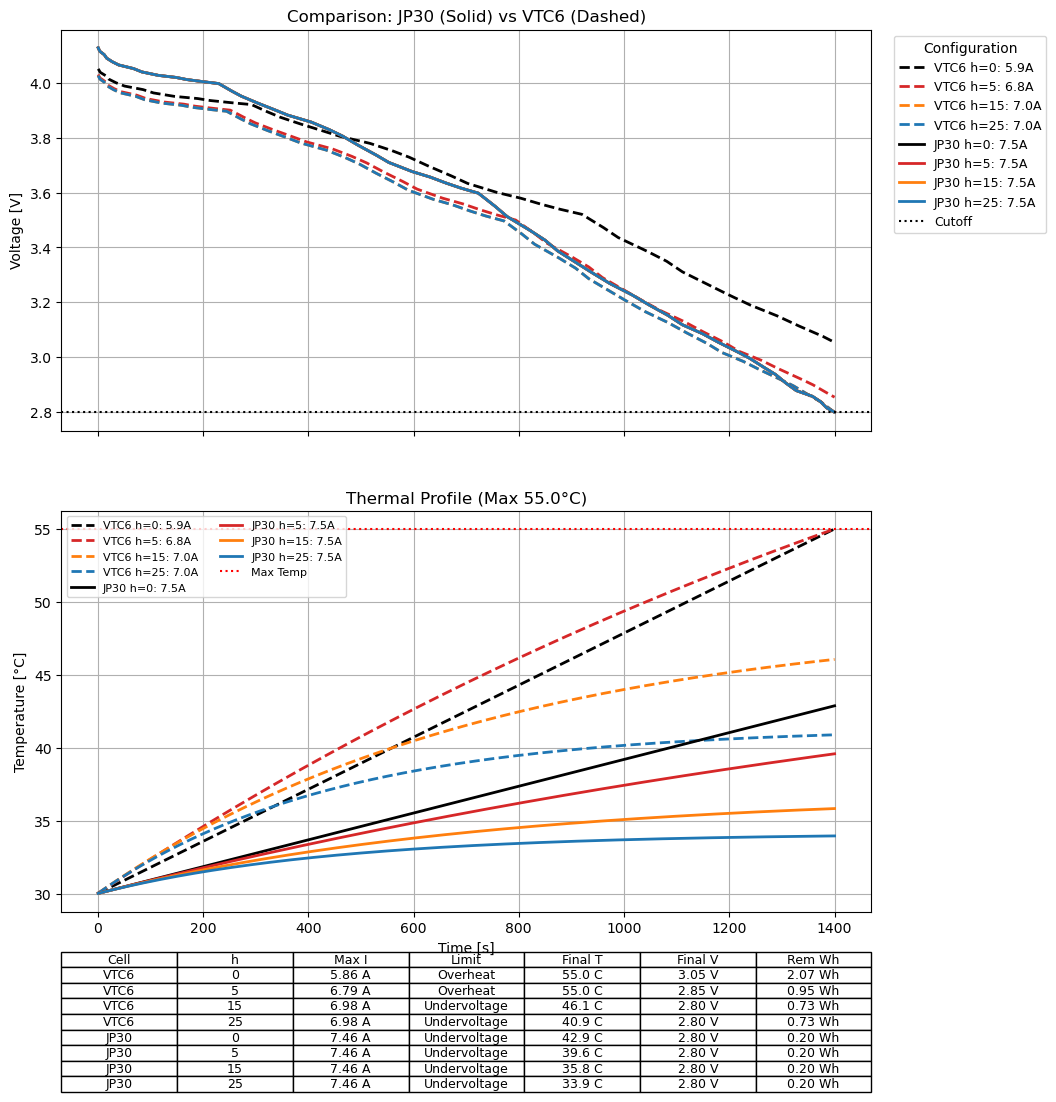

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# %% --- 1. CONFIGURATION ---
Target_Time_s = 1400
Target_Capacity_Wh = 10.6
Target_Capacity_J = Target_Capacity_Wh * 3600

# Limits
V_min = 2.8
T_max = 55.0
T_initial = 30.0

# Geometry (18650)
d_m = 18 / 1000
L_m = 65 / 1000
Area_total_m2 = (np.pi * d_m * L_m) + (2 * np.pi * (d_m/2)**2)
Exposed_Factor = 0.9
Coolable_Area_m2 = Area_total_m2 * Exposed_Factor

# Cell Definitions
cells = [
    {"name": "VTC6", "R": 0.022, "m": 0.047, "Cp": 900, "style": "--"},
    {"name": "JP30", "R": 0.007, "m": 0.047, "Cp": 900, "style": "-"} # Lower R, solid line
]

# Scenarios
h_scenarios = [0, 5, 15, 25] 

# %% --- 2. DATA IMPORT ---
csv_path = r"C:\Pythoning\Vtc6BasicCellLookup.csv"
try:
    lookup_data = pd.read_csv(csv_path)
    voc_vec = lookup_data.iloc[:, 0].values
    raw_joules = lookup_data.iloc[:, 3].values
    joules_vec = (raw_joules / np.max(raw_joules)) * Target_Capacity_J
    voc_interpolator = interp1d(joules_vec, voc_vec, kind='linear', fill_value="extrapolate")
except:
    # Fallback to constant voltage if CSV missing
    voc_interpolator = lambda x: 3.6

# %% --- 3. SIMULATION CORE ---
def run_simulation(current, h_coeff, cell_params, detailed=False):
    dt = 1
    joules_used = 0
    current_temp = T_initial
    step = 0
    max_steps = int(Target_Time_s * 1.5)
    
    R = cell_params["R"]
    m = cell_params["m"]
    Cp = cell_params["Cp"]
    
    history = []
    stop_reason = "Time Reached"
    
    while True:
        step += 1
        t = step * dt
        
        # A. Lookup OCV
        current_joules_state = min(joules_used, Target_Capacity_J)
        Voc = float(voc_interpolator(current_joules_state))
        
        # B. Electrical
        Vcc = Voc - (current * R)
        P_elec = Vcc * current
        
        # C. Thermal
        Q_gen = (current ** 2) * R
        Q_cool = h_coeff * Coolable_Area_m2 * (current_temp - T_initial)
        current_temp += ((Q_gen - Q_cool) * dt) / (m * Cp)
        
        # D. Energy
        joules_used += (P_elec * dt) + (Q_gen * dt)
        
        if detailed:
            history.append([t, Voc, Vcc, current_temp, joules_used])

        # E. Constraints
        if Vcc <= V_min:
            stop_reason = "Undervoltage"
            break
        if current_temp >= T_max:
            stop_reason = "Overheat"
            break
        if joules_used >= Target_Capacity_J:
            stop_reason = "Empty"
            break
        if t >= Target_Time_s and not detailed:
            break
        if detailed and step >= max_steps:
            break
            
    if detailed:
        return np.array(history), stop_reason
    else:
        return t, stop_reason

# %% --- 4. OPTIMIZATION LOOP ---
results_data = [] 
plot_data = []    

# Colors for H (Cooling)
colors = {0: 'black', 5: 'tab:red', 15: 'tab:orange', 25: 'tab:blue'}

print(f"{'Cell':<6} | {'h':<4} | {'Max I':<10} | {'Limit':<15} | {'Temp':<8} | {'Vcc':<8} | {'Rem Wh'}")
print("-" * 80)

for cell in cells:
    for h in h_scenarios:
        low_I, high_I = 0.1, 50.0
        best_I = 0.0
        limit_reason = "None"
        
        # Binary Search
        for _ in range(15):
            mid_I = (low_I + high_I) / 2
            surv_time, reason = run_simulation(mid_I, h, cell, detailed=False)
            
            if surv_time >= Target_Time_s:
                best_I = mid_I
                low_I = mid_I
            else:
                limit_reason = reason
                high_I = mid_I
        
        # Final Run
        sim_data, final_reason = run_simulation(best_I, h, cell, detailed=True)
        
        # Stats
        f_temp = sim_data[-1, 3]
        f_vcc = sim_data[-1, 2]
        f_joules_used = sim_data[-1, 4]
        f_wh_rem = max(0, (Target_Capacity_J - f_joules_used) / 3600)
        
        # Store for Table
        print(f"{cell['name']:<6} | {h:<4} | {best_I:.2f} A     | {limit_reason:<15} | {f_temp:.1f} C   | {f_vcc:.2f} V | {f_wh_rem:.2f}")
        
        results_data.append([
            cell['name'], 
            str(h), 
            f"{best_I:.2f} A", 
            limit_reason, 
            f"{f_temp:.1f} C", 
            f"{f_vcc:.2f} V",
            f"{f_wh_rem:.2f} Wh"
        ])
        
        # Store for Plot
        label = f"{cell['name']} h={h}: {best_I:.1f}A"
        plot_data.append({
            "t": sim_data[:, 0],
            "vcc": sim_data[:, 2],
            "temp": sim_data[:, 3],
            "color": colors[h],
            "style": cell['style'],
            "label": label
        })

# %% --- 5. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), sharex=True)
# Adjust layout to fit external legend and bottom table
plt.subplots_adjust(right=0.8, bottom=0.25, hspace=0.2) 

for entry in plot_data:
    ax1.plot(entry["t"], entry["vcc"], color=entry["color"], linestyle=entry["style"], linewidth=2, label=entry["label"])
    ax2.plot(entry["t"], entry["temp"], color=entry["color"], linestyle=entry["style"], linewidth=2, label=entry["label"])

# Graph 1
ax1.set_title("Comparison: JP30 (Solid) vs VTC6 (Dashed)")
ax1.set_ylabel("Voltage [V]")
ax1.axhline(y=V_min, color='k', linestyle=':', label='Cutoff')
# External Legend for Clarity
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9, title="Configuration") 
ax1.grid(True)

# Graph 2
ax2.set_title(f"Thermal Profile (Max {T_max}°C)")
ax2.set_ylabel("Temperature [°C]")
ax2.set_xlabel("Time [s]")
ax2.axhline(y=T_max, color='r', linestyle=':', label='Max Temp')
ax2.grid(True)
# Internal Legend (Top Left)
ax2.legend(loc='upper left', fontsize=8, ncol=2) 

# Table
col_labels = ["Cell", "h", "Max I", "Limit", "Final T", "Final V", "Rem Wh"]
table = plt.table(cellText=results_data, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0.0, -0.45, 1.0, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(9)

plt.show()

I am moving into the constant power realm, because of the higher closed circuit voltage the new cell is even better. 

Cell   | h    | Max Pwr    | Limit           | Temp     | Vcc      | Rem Wh
--------------------------------------------------------------------------------
VTC6   | 0    | 21.11 W     | Overheat        | 55.0 C   | 3.03 V | 2.10
VTC6   | 5    | 23.37 W     | Overheat        | 55.0 C   | 2.86 V | 1.13
VTC6   | 15   | 23.98 W     | Undervoltage    | 47.5 C   | 2.80 V | 0.87
VTC6   | 25   | 23.98 W     | Undervoltage    | 42.6 C   | 2.80 V | 0.87
JP30   | 0    | 26.18 W     | Undervoltage    | 42.8 C   | 2.80 V | 0.27
JP30   | 5    | 26.18 W     | Undervoltage    | 39.9 C   | 2.80 V | 0.27
JP30   | 15   | 26.18 W     | Undervoltage    | 36.5 C   | 2.80 V | 0.27
JP30   | 25   | 26.18 W     | Undervoltage    | 34.7 C   | 2.80 V | 0.27


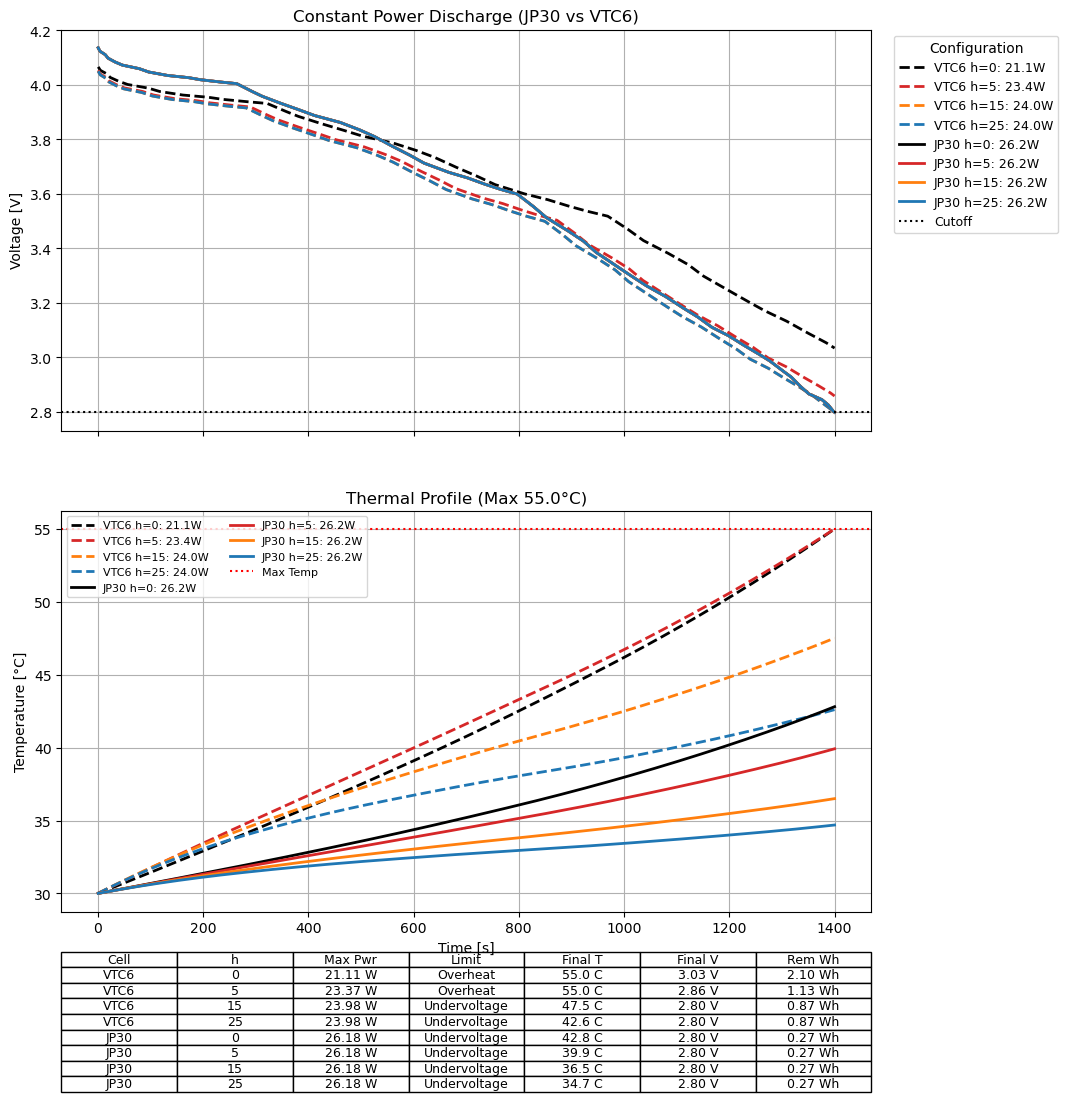

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# %% --- 1. CONFIGURATION ---
Target_Time_s = 1400
Target_Capacity_Wh = 10.6
Target_Capacity_J = Target_Capacity_Wh * 3600

# Limits
V_min = 2.8
T_max = 55.0
T_initial = 30.0

# Geometry (18650)
d_m = 18 / 1000
L_m = 65 / 1000
Area_total_m2 = (np.pi * d_m * L_m) + (2 * np.pi * (d_m/2)**2)
Exposed_Factor = 0.9
Coolable_Area_m2 = Area_total_m2 * Exposed_Factor

# Cell Definitions
cells = [
    {"name": "VTC6", "R": 0.022, "m": 0.047, "Cp": 900, "style": "--"},
    {"name": "JP30", "R": 0.007, "m": 0.047, "Cp": 900, "style": "-"} 
]

# Scenarios
h_scenarios = [0, 5, 15, 25] 

# %% --- 2. DATA IMPORT ---
csv_path = r"C:\Pythoning\Vtc6BasicCellLookup.csv"
try:
    lookup_data = pd.read_csv(csv_path)
    voc_vec = lookup_data.iloc[:, 0].values
    raw_joules = lookup_data.iloc[:, 3].values
    joules_vec = (raw_joules / np.max(raw_joules)) * Target_Capacity_J
    voc_interpolator = interp1d(joules_vec, voc_vec, kind='linear', fill_value="extrapolate")
except:
    # Fallback to constant voltage if CSV missing
    voc_interpolator = lambda x: 3.6

# %% --- 3. SIMULATION CORE (Constant Power) ---
def run_simulation(power_target, h_coeff, cell_params, detailed=False):
    dt = 1
    joules_used = 0
    current_temp = T_initial
    step = 0
    max_steps = int(Target_Time_s * 1.5)
    
    R = cell_params["R"]
    m = cell_params["m"]
    Cp = cell_params["Cp"]
    
    history = []
    stop_reason = "Time Reached"
    
    while True:
        step += 1
        t = step * dt
        
        # A. Lookup OCV
        current_joules_state = min(joules_used, Target_Capacity_J)
        Voc = float(voc_interpolator(current_joules_state))
        
        # B. Electrical Math (Constant Power Solve)
        # We need I such that (Voc - I*R)*I = P
        # Rearranged: R*I^2 - Voc*I + P = 0
        # Quadratic Formula: I = (Voc - sqrt(Voc^2 - 4*R*P)) / (2*R)
        
        discriminant = Voc**2 - 4*R*power_target
        
        if discriminant < 0:
            stop_reason = "Power Limit (Max W)"
            break
            
        # Robust calculation for I (using the minus root for stable discharge)
        # Using the standard form can be numerically unstable if R is tiny, 
        # but 0.007 is large enough for standard float math.
        I_inst = (Voc - np.sqrt(discriminant)) / (2*R)
        
        Vcc = Voc - (I_inst * R)
        
        # C. Thermal
        Q_gen = (I_inst ** 2) * R
        Q_cool = h_coeff * Coolable_Area_m2 * (current_temp - T_initial)
        current_temp += ((Q_gen - Q_cool) * dt) / (m * Cp)
        
        # D. Energy
        # Energy extracted = Power * dt + Heat Losses (Internal)
        # Or simpler: Total Chemical Energy = Voc * I * dt
        P_elec = power_target # By definition
        joules_used += (Voc * I_inst * dt) 
        
        if detailed:
            history.append([t, Voc, Vcc, current_temp, joules_used, I_inst])

        # E. Constraints
        if Vcc <= V_min:
            stop_reason = "Undervoltage"
            break
        if current_temp >= T_max:
            stop_reason = "Overheat"
            break
        if joules_used >= Target_Capacity_J:
            stop_reason = "Empty"
            break
        if t >= Target_Time_s and not detailed:
            break
        if detailed and step >= max_steps:
            break
            
    if detailed:
        return np.array(history), stop_reason
    else:
        return t, stop_reason

# %% --- 4. OPTIMIZATION LOOP ---
results_data = [] 
plot_data = []    

colors = {0: 'black', 5: 'tab:red', 15: 'tab:orange', 25: 'tab:blue'}

# Updated Header for Power
print(f"{'Cell':<6} | {'h':<4} | {'Max Pwr':<10} | {'Limit':<15} | {'Temp':<8} | {'Vcc':<8} | {'Rem Wh'}")
print("-" * 80)

for cell in cells:
    for h in h_scenarios:
        low_P, high_P = 0.1, 200.0 # Watts range
        best_P = 0.0
        limit_reason = "None"
        
        # Binary Search for Max Watts
        for _ in range(15):
            mid_P = (low_P + high_P) / 2
            surv_time, reason = run_simulation(mid_P, h, cell, detailed=False)
            
            if surv_time >= Target_Time_s:
                best_P = mid_P
                low_P = mid_P
            else:
                limit_reason = reason
                high_P = mid_P
        
        # Final Run
        sim_data, final_reason = run_simulation(best_P, h, cell, detailed=True)
        
        # Stats
        f_temp = sim_data[-1, 3]
        f_vcc = sim_data[-1, 2]
        f_joules_used = sim_data[-1, 4]
        f_wh_rem = max(0, (Target_Capacity_J - f_joules_used) / 3600)
        
        # Store for Table
        print(f"{cell['name']:<6} | {h:<4} | {best_P:.2f} W     | {limit_reason:<15} | {f_temp:.1f} C   | {f_vcc:.2f} V | {f_wh_rem:.2f}")
        
        results_data.append([
            cell['name'], 
            str(h), 
            f"{best_P:.2f} W", 
            limit_reason, 
            f"{f_temp:.1f} C", 
            f"{f_vcc:.2f} V",
            f"{f_wh_rem:.2f} Wh"
        ])
        
        # Store for Plot
        label = f"{cell['name']} h={h}: {best_P:.1f}W"
        plot_data.append({
            "t": sim_data[:, 0],
            "vcc": sim_data[:, 2],
            "temp": sim_data[:, 3],
            "color": colors[h],
            "style": cell['style'],
            "label": label
        })

# %% --- 5. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), sharex=True)
plt.subplots_adjust(right=0.8, bottom=0.25, hspace=0.2) 

for entry in plot_data:
    ax1.plot(entry["t"], entry["vcc"], color=entry["color"], linestyle=entry["style"], linewidth=2, label=entry["label"])
    ax2.plot(entry["t"], entry["temp"], color=entry["color"], linestyle=entry["style"], linewidth=2, label=entry["label"])

# Graph 1
ax1.set_title("Constant Power Discharge (JP30 vs VTC6)")
ax1.set_ylabel("Voltage [V]")
ax1.axhline(y=V_min, color='k', linestyle=':', label='Cutoff')
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9, title="Configuration") 
ax1.grid(True)

# Graph 2
ax2.set_title(f"Thermal Profile (Max {T_max}°C)")
ax2.set_ylabel("Temperature [°C]")
ax2.set_xlabel("Time [s]")
ax2.axhline(y=T_max, color='r', linestyle=':', label='Max Temp')
ax2.grid(True)
ax2.legend(loc='upper left', fontsize=8, ncol=2) 

# Table
col_labels = ["Cell", "h", "Max Pwr", "Limit", "Final T", "Final V", "Rem Wh"]
table = plt.table(cellText=results_data, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0.0, -0.45, 1.0, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(9)

plt.show()

Cell   | P  | h   | Max Power (kW)  | Limit           | Temp   | Vcc     
-------------------------------------------------------------------------------------
VTC6   | 4  | 0   | 11.48 kW        | Overheat        | 55.0 C | 412.6 V
VTC6   | 4  | 15  | 13.04 kW        | Undervoltage    | 47.5 C | 380.6 V
VTC6   | 5  | 0   | 14.35 kW        | Overheat        | 55.0 C | 412.6 V
VTC6   | 5  | 15  | 16.31 kW        | Undervoltage    | 47.5 C | 380.5 V
VTC6   | 6  | 0   | 17.23 kW        | Overheat        | 55.0 C | 412.6 V
VTC6   | 6  | 15  | 19.57 kW        | Undervoltage    | 47.5 C | 380.6 V
JP30   | 4  | 0   | 14.24 kW        | Undervoltage    | 42.8 C | 380.6 V
JP30   | 4  | 15  | 14.24 kW        | Undervoltage    | 36.5 C | 380.6 V
JP30   | 5  | 0   | 17.80 kW        | Undervoltage    | 42.8 C | 380.6 V
JP30   | 5  | 15  | 17.80 kW        | Undervoltage    | 36.5 C | 380.6 V
JP30   | 6  | 0   | 21.36 kW        | Undervoltage    | 42.8 C | 380.6 V
JP30   | 6  | 15  | 21.36 kW        |

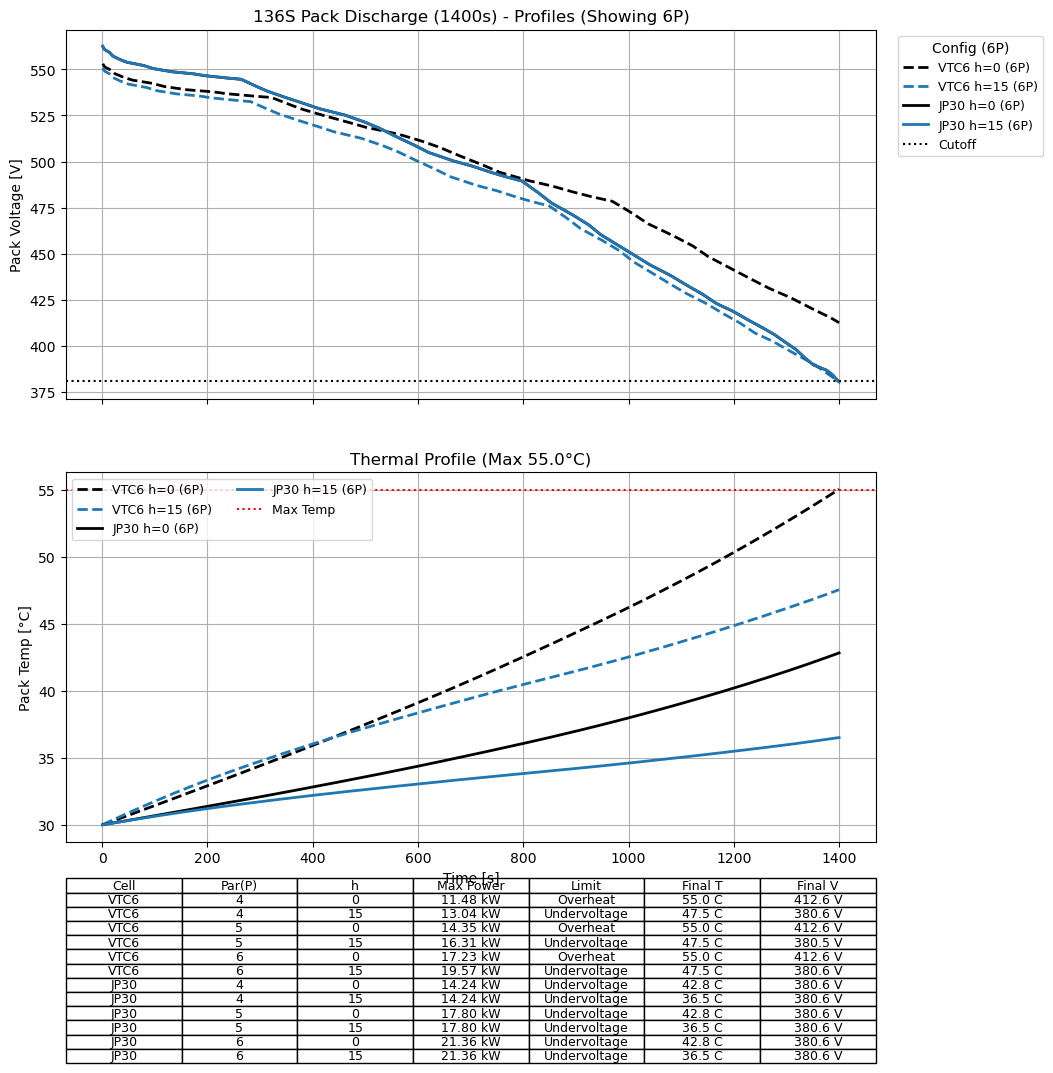

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# %% --- 1. CONFIGURATION ---
Target_Time_s = 1400
Series_Count = 136
Parallel_Counts = [4, 5, 6]  # The variants to test
h_scenarios = [0, 15]        # Adiabatic vs Fan

# Single Cell Constants
Cell_Capacity_Wh = 10.6
V_cell_min = 2.8
T_max = 55.0
T_initial = 30.0
d_m = 18 / 1000
L_m = 65 / 1000

# Geometry Scaling (Surface Area)
# Assuming linear scaling: Pack Area = Cell Area * Total Cells (Ideal cooling)
A_cell = (np.pi * d_m * L_m) + (2 * np.pi * (d_m/2)**2)
Exposed_Factor = 0.9
A_cool_cell = A_cell * Exposed_Factor

# Cell Definitions
cells = [
    {"name": "VTC6", "R": 0.022, "m": 0.047, "Cp": 900, "style": "--"},
    {"name": "JP30", "R": 0.007, "m": 0.047, "Cp": 900, "style": "-"}
]

# %% --- 2. DATA IMPORT ---
csv_path = r"C:\Pythoning\Vtc6BasicCellLookup.csv"
try:
    lookup_data = pd.read_csv(csv_path)
    voc_vec = lookup_data.iloc[:, 0].values
    raw_joules = lookup_data.iloc[:, 3].values
    # Normalized vector to be scaled later per pack size
    norm_joule_vec = raw_joules / np.max(raw_joules)
    
    # Base Interpolator (Normalized Energy -> Cell Voltage)
    # We will scale the input (Pack Energy) back to Normalized Energy inside the loop
    base_voc_interpolator = interp1d(norm_joule_vec, voc_vec, kind='linear', fill_value="extrapolate")
except:
    base_voc_interpolator = lambda x: 3.6

# %% --- 3. SIMULATION CORE ---
def run_pack_simulation(power_target, h_coeff, p_count, cell_params, detailed=False):
    # Scale Pack Parameters
    Total_Cells = Series_Count * p_count
    Pack_Capacity_Wh = Cell_Capacity_Wh * Total_Cells
    Pack_Capacity_J = Pack_Capacity_Wh * 3600
    
    # Electrical Scaling
    # R_pack = R_cell * Series / Parallel
    R_pack = cell_params["R"] * Series_Count / p_count
    
    # Thermal Scaling
    m_pack = cell_params["m"] * Total_Cells
    A_cool_pack = A_cool_cell * Total_Cells # Assuming air reaches all cells
    Cp = cell_params["Cp"]
    
    V_pack_min = V_cell_min * Series_Count
    
    dt = 1
    joules_used = 0
    current_temp = T_initial
    step = 0
    max_steps = int(Target_Time_s * 1.5)
    
    history = []
    stop_reason = "Time Reached"
    
    while True:
        step += 1
        t = step * dt
        
        # A. Lookup OCV (Pack Level)
        # Normalize current energy to 0-1 range to lookup single cell voltage
        energy_fraction = min(joules_used / Pack_Capacity_J, 1.0)
        Voc_cell = float(base_voc_interpolator(energy_fraction))
        Voc_pack = Voc_cell * Series_Count
        
        # B. Electrical (Constant Power)
        # I = (Voc - sqrt(Voc^2 - 4*R*P)) / 2R
        discriminant = Voc_pack**2 - 4*R_pack*power_target
        
        if discriminant < 0:
            stop_reason = "Power Limit"
            break
            
        I_pack = (Voc_pack - np.sqrt(discriminant)) / (2*R_pack)
        Vcc_pack = Voc_pack - (I_pack * R_pack)
        
        # C. Thermal
        Q_gen = (I_pack ** 2) * R_pack
        Q_cool = h_coeff * A_cool_pack * (current_temp - T_initial)
        current_temp += ((Q_gen - Q_cool) * dt) / (m_pack * Cp)
        
        # D. Energy
        joules_used += (Voc_pack * I_pack * dt)
        
        if detailed:
            history.append([t, Voc_pack, Vcc_pack, current_temp, joules_used])

        # E. Constraints
        if Vcc_pack <= V_pack_min:
            stop_reason = "Undervoltage"
            break
        if current_temp >= T_max:
            stop_reason = "Overheat"
            break
        if joules_used >= Pack_Capacity_J:
            stop_reason = "Empty"
            break
        if t >= Target_Time_s and not detailed:
            break
        if detailed and step >= max_steps:
            break
            
    if detailed:
        return np.array(history), stop_reason
    else:
        return t, stop_reason

# %% --- 4. OPTIMIZATION LOOP ---
results_data = [] 
plot_data = []

# Colors for H
colors = {0: 'black', 15: 'tab:blue'}

print(f"{'Cell':<6} | {'P':<2} | {'h':<3} | {'Max Power (kW)':<15} | {'Limit':<15} | {'Temp':<6} | {'Vcc':<8}")
print("-" * 85)

for cell in cells:
    for p in Parallel_Counts:
        for h in h_scenarios:
            
            # Binary Search for Max Pack Watts
            low_P, high_P = 100.0, 500000.0 # Broad range for pack power
            best_P = 0.0
            limit_reason = "None"
            
            for _ in range(18):
                mid_P = (low_P + high_P) / 2
                surv_time, reason = run_pack_simulation(mid_P, h, p, cell, detailed=False)
                
                if surv_time >= Target_Time_s:
                    best_P = mid_P
                    low_P = mid_P
                else:
                    limit_reason = reason
                    high_P = mid_P
            
            # Final Run
            sim_data, final_reason = run_pack_simulation(best_P, h, p, cell, detailed=True)
            
            # Stats
            f_temp = sim_data[-1, 3]
            f_vcc = sim_data[-1, 2]
            kw_power = best_P / 1000.0
            
            print(f"{cell['name']:<6} | {p:<2} | {h:<3} | {kw_power:.2f} kW        | {limit_reason:<15} | {f_temp:.1f} C | {f_vcc:.1f} V")
            
            results_data.append([
                cell['name'], 
                str(p), 
                str(h), 
                f"{kw_power:.2f} kW", 
                limit_reason, 
                f"{f_temp:.1f} C", 
                f"{f_vcc:.1f} V"
            ])
            
            # Only add to plot if it's the 6P case (to reduce clutter)
            # Or we can plot all, they will just overlap.
            # Let's plot only 6P to show the "Best Case" profile, but note the overlap.
            if p == 6:
                label = f"{cell['name']} h={h} (6P)"
                plot_data.append({
                    "t": sim_data[:, 0],
                    "vcc": sim_data[:, 2],
                    "temp": sim_data[:, 3],
                    "color": colors[h],
                    "style": cell['style'],
                    "label": label
                })

# %% --- 5. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), sharex=True)
plt.subplots_adjust(right=0.8, bottom=0.3, hspace=0.2) 

for entry in plot_data:
    ax1.plot(entry["t"], entry["vcc"], color=entry["color"], linestyle=entry["style"], linewidth=2, label=entry["label"])
    ax2.plot(entry["t"], entry["temp"], color=entry["color"], linestyle=entry["style"], linewidth=2, label=entry["label"])

# Graph 1
ax1.set_title(f"136S Pack Discharge ({Target_Time_s}s) - Profiles (Showing 6P)")
ax1.set_ylabel("Pack Voltage [V]")
V_pack_cutoff = V_cell_min * Series_Count
ax1.axhline(y=V_pack_cutoff, color='k', linestyle=':', label='Cutoff')
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9, title="Config (6P)") 
ax1.grid(True)

# Graph 2
ax2.set_title(f"Thermal Profile (Max {T_max}°C)")
ax2.set_ylabel("Pack Temp [°C]")
ax2.set_xlabel("Time [s]")
ax2.axhline(y=T_max, color='r', linestyle=':', label='Max Temp')
ax2.grid(True)
ax2.legend(loc='upper left', fontsize=9, ncol=2)

# Table
col_labels = ["Cell", "Par(P)", "h", "Max Power", "Limit", "Final T", "Final V"]
table = plt.table(cellText=results_data, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0.0, -0.6, 1.0, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(9)

plt.show()

Cell   | P  | h   | Max Power (kW)  | Limit           | Temp   | Vcc     
-------------------------------------------------------------------------------------
VTC6   | 6  | 0   | 17.23 kW        | Overheat        | 55.0 C | 412.6 V
VTC6   | 6  | 15  | 19.57 kW        | Undervoltage    | 47.5 C | 380.6 V
VTC6   | 5  | 0   | 14.35 kW        | Overheat        | 55.0 C | 412.6 V
VTC6   | 5  | 15  | 16.31 kW        | Undervoltage    | 47.5 C | 380.5 V
VTC6   | 4  | 0   | 11.48 kW        | Overheat        | 55.0 C | 412.6 V
VTC6   | 4  | 15  | 13.04 kW        | Undervoltage    | 47.5 C | 380.6 V
JP30   | 6  | 0   | 21.36 kW        | Undervoltage    | 42.8 C | 380.6 V
JP30   | 6  | 15  | 21.36 kW        | Undervoltage    | 36.5 C | 380.6 V
JP30   | 5  | 0   | 17.80 kW        | Undervoltage    | 42.8 C | 380.6 V
JP30   | 5  | 15  | 17.80 kW        | Undervoltage    | 36.5 C | 380.6 V
JP30   | 4  | 0   | 14.24 kW        | Undervoltage    | 42.8 C | 380.6 V
JP30   | 4  | 15  | 14.24 kW        |

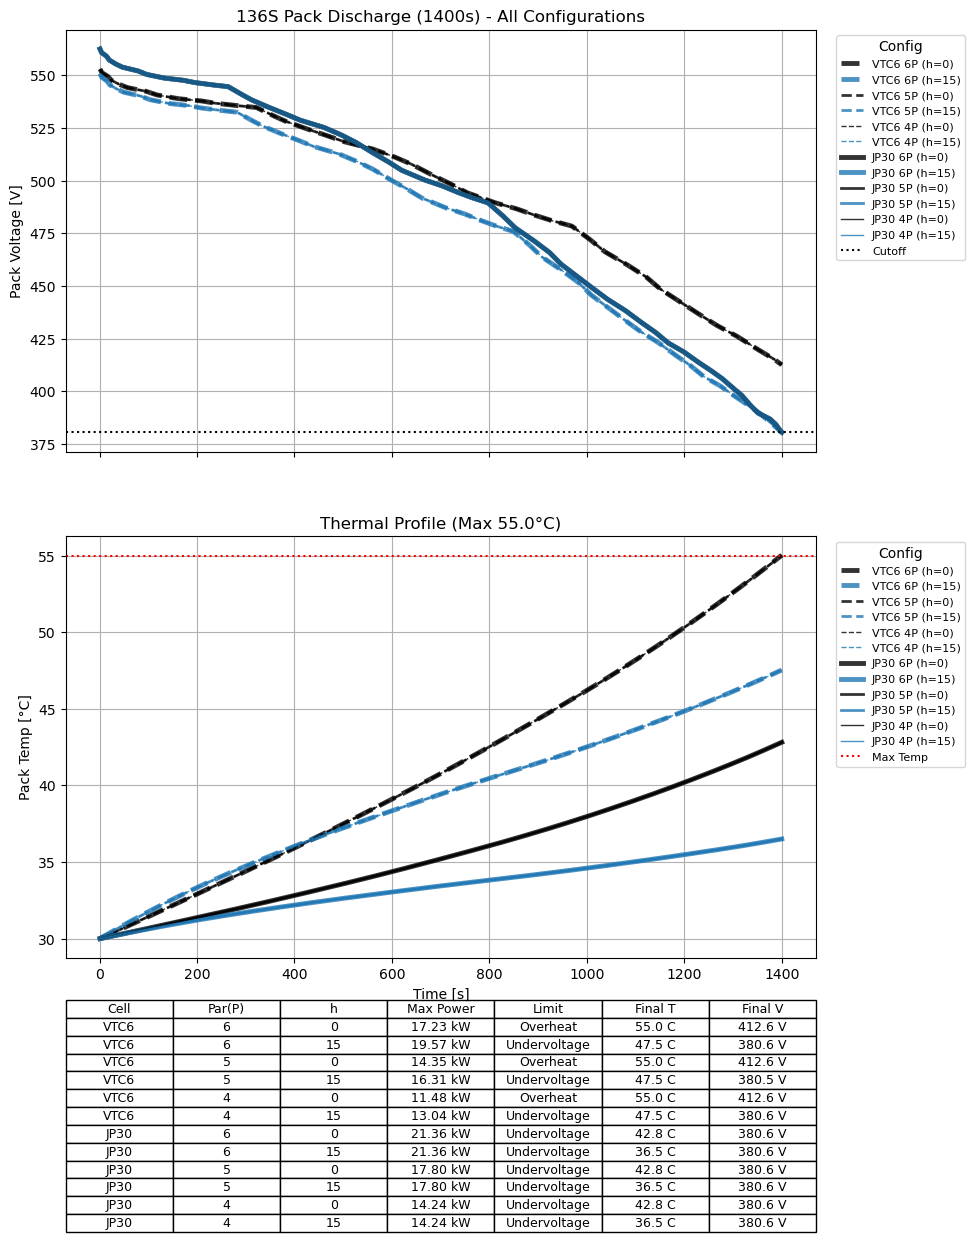

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

# %% --- 1. CONFIGURATION ---
Target_Time_s = 1400
Series_Count = 136
Parallel_Counts = [4, 5, 6]  # Variants
h_scenarios = [0, 15]        # Adiabatic vs Fan

# Single Cell Constants
Cell_Capacity_Wh = 10.6
V_cell_min = 2.8
T_max = 55.0
T_initial = 30.0
d_m = 18 / 1000
L_m = 65 / 1000

# Geometry Scaling
A_cell = (np.pi * d_m * L_m) + (2 * np.pi * (d_m/2)**2)
Exposed_Factor = 0.9
A_cool_cell = A_cell * Exposed_Factor

# Cell Definitions
cells = [
    {"name": "VTC6", "R": 0.022, "m": 0.047, "Cp": 900, "style": "--"},
    {"name": "JP30", "R": 0.007, "m": 0.047, "Cp": 900, "style": "-"}
]

# %% --- 2. DATA IMPORT ---
csv_path = r"C:\Pythoning\Vtc6BasicCellLookup.csv"
try:
    lookup_data = pd.read_csv(csv_path)
    voc_vec = lookup_data.iloc[:, 0].values
    raw_joules = lookup_data.iloc[:, 3].values
    norm_joule_vec = raw_joules / np.max(raw_joules)
    base_voc_interpolator = interp1d(norm_joule_vec, voc_vec, kind='linear', fill_value="extrapolate")
except:
    base_voc_interpolator = lambda x: 3.6

# %% --- 3. SIMULATION CORE ---
def run_pack_simulation(power_target, h_coeff, p_count, cell_params, detailed=False):
    # Scale Pack Parameters
    Total_Cells = Series_Count * p_count
    Pack_Capacity_Wh = Cell_Capacity_Wh * Total_Cells
    Pack_Capacity_J = Pack_Capacity_Wh * 3600
    
    # Electrical Scaling
    R_pack = cell_params["R"] * Series_Count / p_count
    
    # Thermal Scaling
    m_pack = cell_params["m"] * Total_Cells
    A_cool_pack = A_cool_cell * Total_Cells
    Cp = cell_params["Cp"]
    
    V_pack_min = V_cell_min * Series_Count
    
    dt = 1
    joules_used = 0
    current_temp = T_initial
    step = 0
    max_steps = int(Target_Time_s * 1.5)
    
    history = []
    stop_reason = "Time Reached"
    
    while True:
        step += 1
        t = step * dt
        
        # A. Lookup OCV
        energy_fraction = min(joules_used / Pack_Capacity_J, 1.0)
        Voc_cell = float(base_voc_interpolator(energy_fraction))
        Voc_pack = Voc_cell * Series_Count
        
        # B. Electrical (Constant Power)
        discriminant = Voc_pack**2 - 4*R_pack*power_target
        
        if discriminant < 0:
            stop_reason = "Power Limit"
            break
            
        I_pack = (Voc_pack - np.sqrt(discriminant)) / (2*R_pack)
        Vcc_pack = Voc_pack - (I_pack * R_pack)
        
        # C. Thermal
        Q_gen = (I_pack ** 2) * R_pack
        Q_cool = h_coeff * A_cool_pack * (current_temp - T_initial)
        current_temp += ((Q_gen - Q_cool) * dt) / (m_pack * Cp)
        
        # D. Energy
        joules_used += (Voc_pack * I_pack * dt)
        
        if detailed:
            history.append([t, Voc_pack, Vcc_pack, current_temp, joules_used])

        # E. Constraints
        if Vcc_pack <= V_pack_min:
            stop_reason = "Undervoltage"
            break
        if current_temp >= T_max:
            stop_reason = "Overheat"
            break
        if joules_used >= Pack_Capacity_J:
            stop_reason = "Empty"
            break
        if t >= Target_Time_s and not detailed:
            break
        if detailed and step >= max_steps:
            break
            
    if detailed:
        return np.array(history), stop_reason
    else:
        return t, stop_reason

# %% --- 4. OPTIMIZATION LOOP ---
results_data = [] 
plot_data = []

# Colors for H (Blue for Fan, Black for Adiabatic)
colors = {0: 'black', 15: 'tab:blue'}

# Line Widths for Parallel Count (Thicker = More Parallel)
widths = {4: 1.0, 5: 2.0, 6: 3.5}

print(f"{'Cell':<6} | {'P':<2} | {'h':<3} | {'Max Power (kW)':<15} | {'Limit':<15} | {'Temp':<6} | {'Vcc':<8}")
print("-" * 85)

for cell in cells:
    # Sort Parallel counts so we plot thickest lines first (or last depending on pref)
    # If we plot thickest first, thin lines will sit on top and be visible.
    for p in reversed(Parallel_Counts): # 6 -> 5 -> 4
        for h in h_scenarios:
            
            # Binary Search
            low_P, high_P = 100.0, 500000.0 
            best_P = 0.0
            limit_reason = "None"
            
            for _ in range(18):
                mid_P = (low_P + high_P) / 2
                surv_time, reason = run_pack_simulation(mid_P, h, p, cell, detailed=False)
                
                if surv_time >= Target_Time_s:
                    best_P = mid_P
                    low_P = mid_P
                else:
                    limit_reason = reason
                    high_P = mid_P
            
            # Final Run
            sim_data, final_reason = run_pack_simulation(best_P, h, p, cell, detailed=True)
            
            # Stats
            f_temp = sim_data[-1, 3]
            f_vcc = sim_data[-1, 2]
            kw_power = best_P / 1000.0
            
            print(f"{cell['name']:<6} | {p:<2} | {h:<3} | {kw_power:.2f} kW        | {limit_reason:<15} | {f_temp:.1f} C | {f_vcc:.1f} V")
            
            results_data.append([
                cell['name'], 
                str(p), 
                str(h), 
                f"{kw_power:.2f} kW", 
                limit_reason, 
                f"{f_temp:.1f} C", 
                f"{f_vcc:.1f} V"
            ])
            
            # Store Plot Data
            label = f"{cell['name']} {p}P (h={h})"
            plot_data.append({
                "t": sim_data[:, 0],
                "vcc": sim_data[:, 2],
                "temp": sim_data[:, 3],
                "color": colors[h],
                "style": cell['style'],
                "width": widths[p],
                "label": label
            })

# %% --- 5. PLOTTING ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), sharex=True)
plt.subplots_adjust(right=0.75, bottom=0.3, hspace=0.2) 

for entry in plot_data:
    ax1.plot(entry["t"], entry["vcc"], 
             color=entry["color"], 
             linestyle=entry["style"], 
             linewidth=entry["width"], 
             label=entry["label"],
             alpha=0.8) # Slight transparency to help see overlaps
             
    ax2.plot(entry["t"], entry["temp"], 
             color=entry["color"], 
             linestyle=entry["style"], 
             linewidth=entry["width"], 
             label=entry["label"],
             alpha=0.8)

# Graph 1
ax1.set_title(f"136S Pack Discharge ({Target_Time_s}s) - All Configurations")
ax1.set_ylabel("Pack Voltage [V]")
V_pack_cutoff = V_cell_min * Series_Count
ax1.axhline(y=V_pack_cutoff, color='k', linestyle=':', label='Cutoff')

# Graph 2
ax2.set_title(f"Thermal Profile (Max {T_max}°C)")
ax2.set_ylabel("Pack Temp [°C]")
ax2.set_xlabel("Time [s]")
ax2.axhline(y=T_max, color='r', linestyle=':', label='Max Temp')

# LEGEND MANAGEMENT
# Since we have many lines, we put the legend outside
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8, title="Config") 
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=8, title="Config")
ax1.grid(True)
ax2.grid(True)

# Table
col_labels = ["Cell", "Par(P)", "h", "Max Power", "Limit", "Final T", "Final V"]
# Sort results for readability in table? They are appended in loop order.
table = plt.table(cellText=results_data, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0.0, -0.65, 1.0, 0.55])
table.auto_set_font_size(False)
table.set_fontsize(9)

plt.show()